<a href="https://colab.research.google.com/github/sudip234-source/PyTorch-Tutorial/blob/main/ANN_fashion_mnist_gpu_optimized_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [47]:
torch.manual_seed(42)

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print( device)

cuda


In [49]:
df = pd.read_csv('/content/drive/MyDrive/Data Sets files/fashion-mnist_test.csv')
df.head(
)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


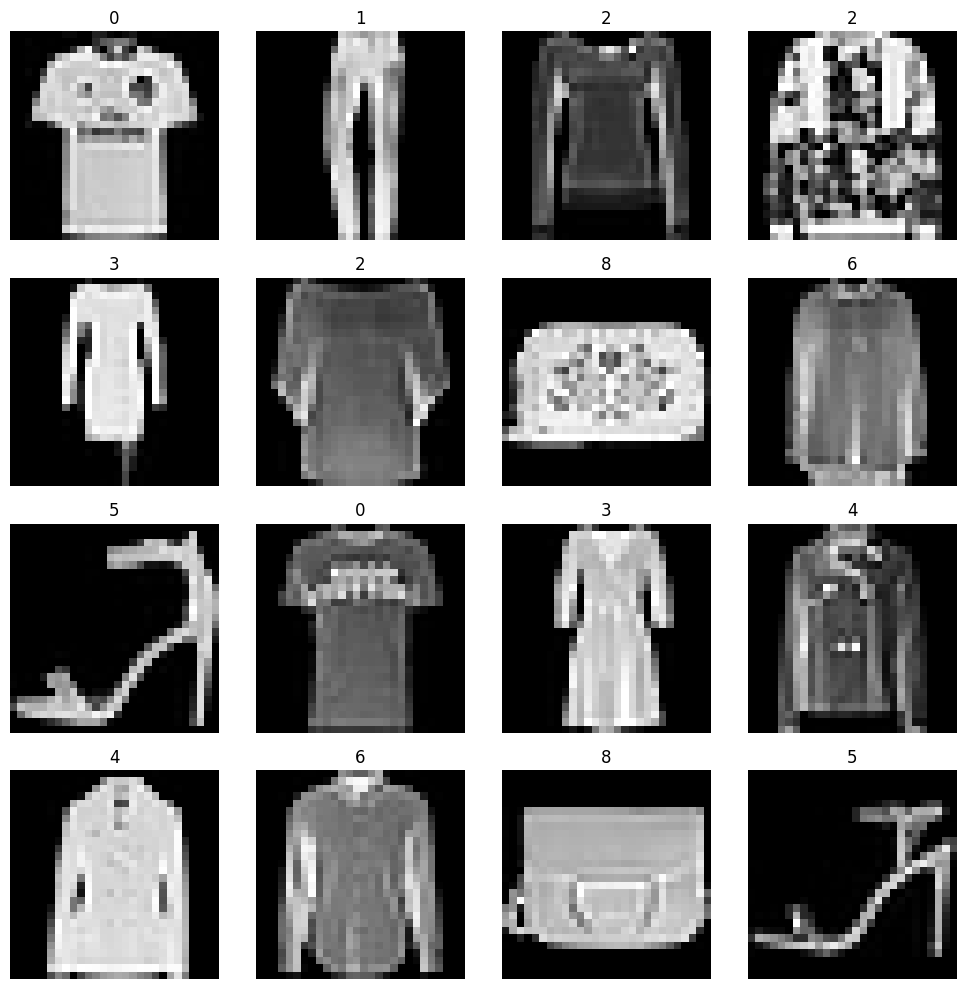

In [50]:
plt.figure(figsize=(10, 10))  # Big figure for 4x4 grid

for i in range(16):
    plt.subplot(4, 4, i + 1)  # 4 rows, 4 columns
    plt.imshow(df.iloc[i, 1:].values.reshape(28, 28), cmap='gray')
    plt.title(df.iloc[i, 0])
    plt.axis('off')  # Turn off x and y axis

plt.tight_layout()
plt.show()

In [51]:
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [52]:
X.shape,y.shape

((10000, 784), (10000,))

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((8000, 784), (2000, 784), (8000,), (2000,))

In [55]:
X_train_tensor = torch.tensor(X_train/255.0, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test/255.0, dtype=torch.float32)

In [56]:
X_train_tensor

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.4510, 0.1373, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [57]:
class CustomDataset(Dataset):
  def __init__(self,X,y):
    self.X = X
    self.y = torch.tensor(y,dtype=torch.long)

  def __len__(self):
      return len(self.y)

  def __getitem__(self,index):
      return self.X[index],self.y[index]

In [58]:
train_dataset = CustomDataset(X_train_tensor,y_train)
test_dataset = CustomDataset(X_test_tensor,y_test)

In [59]:
train_dataset[0][1]

tensor(8)

In [60]:
len(train_dataset)

8000

In [61]:
class MyNN(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):

    super().__init__()

    layers = []

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):

    return self.model(x)

In [62]:
# objective function
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

  if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
      optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
      optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()


  # evaluation
  model.eval()
  # evaluation on test data
  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _, predicted = torch.max(outputs, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [63]:
!pip install optuna

In [65]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-06-08 11:16:19,455] A new study created in memory with name: no-name-3fb001e3-b329-4d88-baeb-dbb367c848b1
[I 2025-06-08 11:16:31,467] Trial 0 finished with value: 0.8385 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 48, 'epochs': 20, 'learning_rate': 0.00021172861829898623, 'dropout_rate': 0.30210209469938043, 'batch_size': 64, 'optimizer': 'RMSprop', 'weight_decay': 3.956477380952458e-05}. Best is trial 0 with value: 0.8385.
[I 2025-06-08 11:16:33,578] Trial 1 finished with value: 0.7225 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 16, 'epochs': 10, 'learning_rate': 0.025733627442397575, 'dropout_rate': 0.2582550781386579, 'batch_size': 128, 'optimizer': 'Adam', 'weight_decay': 0.0002797618465004185}. Best is trial 0 with value: 0.8385.
[I 2025-06-08 11:16:43,300] Trial 2 finished with value: 0.8265 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 24, 'epochs': 40, 'learning_rate': 0.020889012743107505, 'dropout_rate': 0.1457263241

In [66]:
study.best_params

{'num_hidden_layers': 5,
 'neurons_per_layer': 88,
 'epochs': 10,
 'learning_rate': 0.00018630936940910976,
 'dropout_rate': 0.14105689719465878,
 'batch_size': 32,
 'optimizer': 'RMSprop',
 'weight_decay': 1.9786709515608338e-05}

In [67]:
study.best_value

0.858